# 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기

CutMix + Mixup 적용해 모델을 훈련시키자.


<br>

### 루브릭 


---


1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
        - CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?
        - Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
        - 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.
<br>

## 1. Augmentation을 적용한 데이터셋 만들기


---

- 데이터셋에 CutMix, Mixup augmentation을 적용
- batch()함수 뒤에 Cutmix가 들어간다

### 1.1 Data load

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

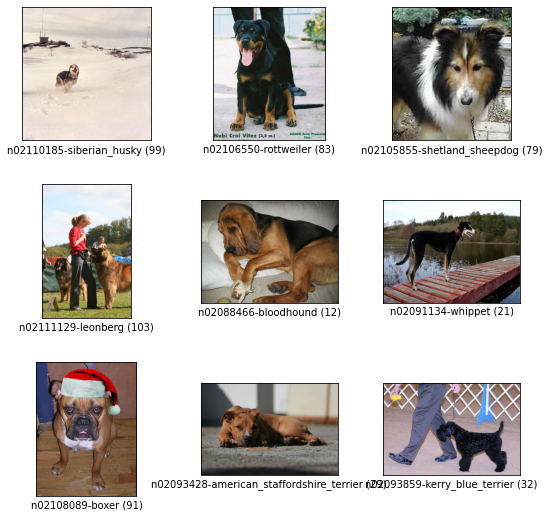

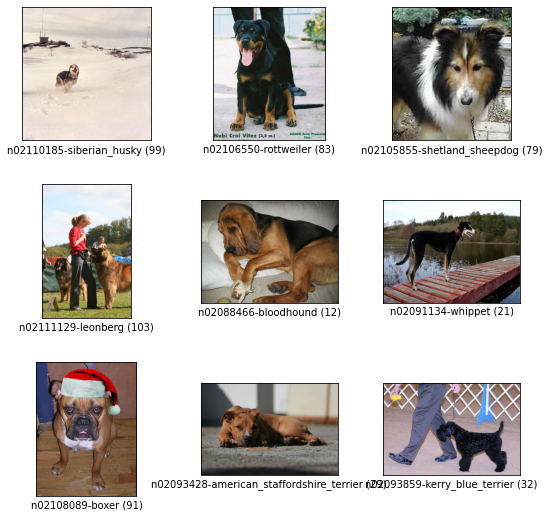

In [3]:
tfds.show_examples(ds_train, ds_info)

### 1.2 Augmentation 적용
- 텐서플로우 random augmentation api
        random_brightness()
        random_contrast()
        random_crop()
        random_flip_left_right()
        random_flip_up_down()
        random_hue()
        random_jpeg_quality()
        random_saturation()

In [4]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):     # 변환할 이미지, 라벨
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])  # 이미지 사이즈 변환
    return tf.cast(image, tf.float32) / 255., label

# flip, brightness
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### 1.3 Cutmix Augmentation : mixup + cutout

- `get_clip_box()` : 첫번째 이미지 a를 바탕 이미지로 하고 삽입할 두번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
- `mix_2_images()` : 바탕 이미지 image_a에서 바운딩 박스 바깥쪽 영역, image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
- `mix_2_labels()` : 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두가지 라벨의 비율로 더해주는 함수
- `cutmix()` : mix_2_images() + mix_2_labels()

In [5]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [6]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [7]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [8]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 1.4 Mixup Augmentation : 두 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식의 augmentation 기법
- cutmix보다 구현이 간단하다
- 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑는다
- 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다

In [9]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [10]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [11]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

In [12]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    
    # 기본적인 전처리 함수 적용
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    # augment
    if not is_test and with_aug:        
        ds = ds.map(augment)

    ds = ds.batch(batch_size)

    # cutmix
    if not is_test and with_cutmix:     
        ds = ds.map(cutmix, num_parallel_calls=2)

    # mixup
    elif not is_test and with_mixup:      
        ds = ds.map(mixup, num_parallel_calls=2)
    
    # onehot
    else:
        ds = ds.map(onehot, num_parallel_calls=2)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

- `normalize_and_resize_img()` : 기본 전처리 함수
- `augment()` : random_flip_left_right, random_brightness
- `apply_normalize_on_dataset()` : 원본 데이터셋에 다양한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수, with_aug 매개변수로 aug 적용을 결정
- suffle이나 augmentation은 테스트셋에는 적용하면 안 됨

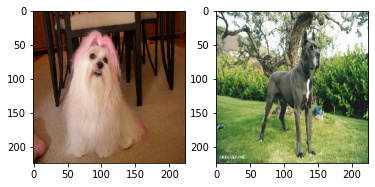

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

## 2. 모델 만들기

---


- 비교 실험을 위한 모델 두 개 생성
- ResNet-50
- aug 적용한 데이터 학습시킨 모델 vs 안한 모델 성능 비교
- `include_top`: 마지막 fc layer 포함 여부, 해당 레이어를 포함하지 않고 생성하면 수정된 레이어를 붙여서 활용할 수 있다

In [14]:
num_classes = ds_info.features["label"].num_classes

# no augmentation
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [15]:
# basic augmentation
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [16]:
# cutmix
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
# mixup
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [18]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
# ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)  # aug X
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)      # aug O
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True) # basic + cutmix
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)   # basic + mixup
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 3. 모델 훈련 및 시각화


---



In [19]:
EPOCH = 20

In [20]:
# no augmentation
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 110s 129ms/step - loss: 2.2072 - accuracy: 0.4485 - val_loss: 3.1718 - val_accuracy: 0.2484
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 0.6672 - accuracy: 0.8187 - val_loss: 1.0756 - val_accuracy: 0.6911
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 0.1899 - accuracy: 0.9619 - val_loss: 0.9591 - val_accuracy: 0.7219
Epoch 4/20
750/750 [==============================] - 94s 125ms/step - loss: 0.0777 - accuracy: 0.9912 - val_loss: 0.9253 - val_accuracy: 0.7393
Epoch 5/20
750/750 [==============================] - 94s 125ms/step - loss: 0.0278 - accuracy: 0.9983 - val_loss: 0.9312 - val_accuracy: 0.7432
Epoch 6/20
750/750 [==============================] - 94s 125ms/step - loss: 0.0126 - accuracy: 0.9998 - val_loss: 0.9334 - val_accuracy: 0.7416
Epoch 7/20
750/750 [==============================] - 94s 125ms/step - loss: 0.0110 - accuracy: 0.9998 - val_loss: 0.9628 - val_accuracy: 0.

In [21]:
# augmentation
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 104s 127ms/step - loss: 2.2740 - accuracy: 0.4346 - val_loss: 2.8223 - val_accuracy: 0.3006
Epoch 2/20
750/750 [==============================] - 94s 125ms/step - loss: 0.9131 - accuracy: 0.7412 - val_loss: 1.4520 - val_accuracy: 0.5837
Epoch 3/20
750/750 [==============================] - 92s 123ms/step - loss: 0.4892 - accuracy: 0.8655 - val_loss: 1.1871 - val_accuracy: 0.6593
Epoch 4/20
750/750 [==============================] - 92s 123ms/step - loss: 0.2628 - accuracy: 0.9381 - val_loss: 1.1043 - val_accuracy: 0.6858
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 0.1789 - accuracy: 0.9606 - val_loss: 1.0382 - val_accuracy: 0.7067
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0924 - accuracy: 0.9851 - val_loss: 0.9948 - val_accuracy: 0.7222
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0526 - accuracy: 0.9932 - val_loss: 0.9811 - val_accuracy: 0.

In [22]:
# cutmix
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 105s 128ms/step - loss: 3.8974 - accuracy: 0.1912 - val_loss: 3.2989 - val_accuracy: 0.2295
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 3.0589 - accuracy: 0.3949 - val_loss: 1.5109 - val_accuracy: 0.5770
Epoch 3/20
750/750 [==============================] - 95s 127ms/step - loss: 2.7863 - accuracy: 0.4827 - val_loss: 1.4367 - val_accuracy: 0.5999
Epoch 4/20
750/750 [==============================] - 94s 125ms/step - loss: 2.5862 - accuracy: 0.5410 - val_loss: 1.2664 - val_accuracy: 0.6411
Epoch 5/20
750/750 [==============================] - 94s 125ms/step - loss: 2.4422 - accuracy: 0.5849 - val_loss: 1.2894 - val_accuracy: 0.6459
Epoch 6/20
750/750 [==============================] - 94s 125ms/step - loss: 2.3669 - accuracy: 0.6133 - val_loss: 1.1677 - val_accuracy: 0.6795
Epoch 7/20
750/750 [==============================] - 95s 127ms/step - loss: 2.2535 - accuracy: 0.6429 - val_loss: 1.2757 - val_accuracy: 0.

In [23]:
# mixup
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 105s 128ms/step - loss: 3.7729 - accuracy: 0.2280 - val_loss: 3.4033 - val_accuracy: 0.1974
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 2.9381 - accuracy: 0.4524 - val_loss: 1.8285 - val_accuracy: 0.5209
Epoch 3/20
750/750 [==============================] - 95s 127ms/step - loss: 2.6946 - accuracy: 0.5414 - val_loss: 1.3523 - val_accuracy: 0.6281
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 2.5208 - accuracy: 0.5994 - val_loss: 1.2429 - val_accuracy: 0.6468
Epoch 5/20
750/750 [==============================] - 95s 126ms/step - loss: 2.3581 - accuracy: 0.6627 - val_loss: 1.2270 - val_accuracy: 0.6623
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 2.2892 - accuracy: 0.6869 - val_loss: 1.3384 - val_accuracy: 0.6333
Epoch 7/20
750/750 [==============================] - 95s 126ms/step - loss: 2.2417 - accuracy: 0.7039 - val_loss: 1.2035 - val_accuracy: 0.

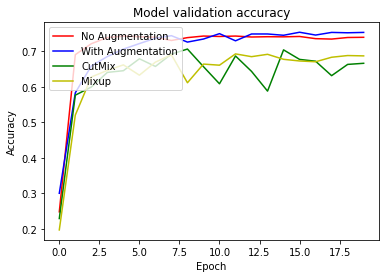

In [24]:
# 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.show()

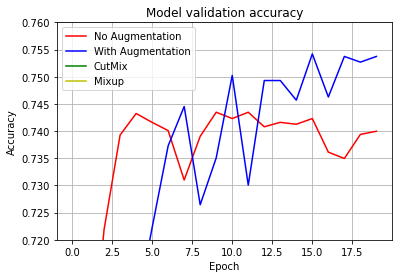

In [25]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()